# **Task 2: Visualizing Attention and Analyzing the “Attention Sink” Phenomenon**

## **Overview**
Explores **Transformer self-attention** by capturing, visualizing, and quantifying attention maps, then simulates how **StreamLLM** leverages the *“attention sink”* to enable long-sequence generation with fixed memory.  
The notebook adds `output_attentions=True` for introspection, builds a hook-based **Attention Catcher**, measures sink attention across layers, and contrasts standard **KV caching** with a **StreamLLM-style cache** that trims middle tokens while preserving sinks and recency.

---

## **Step 1: Load the Model in Investigation Mode (Cell 4)**

- **Enable attention outputs:**  
  Load the model with  
  `AutoModelForCausalLM.from_pretrained(..., output_attentions=True)`  
  so each forward pass returns per-layer attention tensors alongside logits.

- **Tokenization setup:**  
  Initialize the matching `AutoTokenizer` and standard generation configs used throughout experiments.

---

## **Step 2: Build the “Attention Catcher” Toolkit (Cell 5)**

- **Global storage:**  
  `attention_maps_storage` keeps captured attention tensors keyed by layer/module identifiers.

- **Hook factory:**  
  `get_attention_hook` returns a forward hook that extracts `attn_weights` during the pass and stores them in `attention_maps_storage`.

- **Hook registrar:**  
  `register_attention_hooks(model, layers=...)` attaches the hook to each chosen self-attention module (single layer, a subset, or all layers).

- **Visualization:**  
  `plot_attention_maps` retrieves saved maps, aggregates across heads (e.g., mean over heads), and renders **attention heatmaps** for inspection.

---

## **Step 3: Experiment 1 — Attention Patterns Across Inputs (Cell 6)**

- **Inputs:**  
  Define `INPUT_TEXTS` with both meaningful sentences and repetitive “dummy” strings of varying lengths.

- **Hook installation:**  
  Call `register_attention_hooks` for selected layers; clear `attention_maps_storage` before each run.

- **Single forward pass:**  
  Tokenize each input and run a forward pass to populate attention storage via hooks.

- **Heatmaps:**  
  Use `plot_attention_maps` to visualize per-layer attention, aggregated across heads, for side-by-side comparison across inputs.

- **Cleanup:**  
  Remove all hooks after the experiment to avoid extra overhead later.

---

## **Step 4: Experiment 2 — Quantifying the Attention Sink (Cell 7)**

- **Full-depth monitoring:**  
  Register hooks on every layer to capture a complete attention profile across the model.

- **Sink metric:**  
  For each input and layer, compute the fraction of attention mass directed to the first `SINK_TOKEN_WINDOW` tokens, averaging across heads and query positions.

- **Trends by layer:**  
  Store results and plot layer-wise curves  
  *(x-axis: layer ID; y-axis: sink attention %)*  
  with separate lines per input type to reveal consistent sink patterns.

---

## **Step 5 (Advanced): StreamLLM Simulation and Memory Advantage (Cells 8–9)**

- **Positional shift attention:**  
  `llama_pos_shift_attention_forward` modifies the attention forward path to dynamically adjust positional encodings (e.g., RoPE phases) when intermediate tokens are evicted, preserving correct relative positions among the remaining tokens.

- **KV cache manager:**  
  `streamingllm_kv` tracks and trims the KV cache by discarding middle tokens once capacity is exceeded, keeping only early “sink” tokens and the most recent tokens.

- **Baseline vs. StreamLLM:**  
  - `run_baseline_experiment`: Standard generation where KV cache grows linearly with sequence length; log memory usage over steps.  
  - `run_streamllm_experiment`: Generation with `streamingllm_kv` trimming after each step; log memory usage for comparison.

- **Analysis:**  
  Plot both memory curves against generated tokens to show linear growth (**baseline**) vs. plateau (**StreamLLM-style trimming**), illustrating fixed-memory long-context generation.

---

## **Results and Takeaways**

- **Memory efficiency:**  
  StreamLLM-style KV trimming flattens memory growth, enabling sustained generation without exhausting memory.

- **Output quality:**  
  Standard full-cache generation degrades (e.g., incoherent characters) far beyond training lengths, while StreamLLM maintains more coherent outputs under extended contexts.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
### Cell 2: Environment Setup and Dependency Imports
# TODO: import all required libraries (os, random, numpy, pandas, torch, transformers, etc.)
import os
import random
import numpy as np
import pandas as pd
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, StoppingCriteria
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional

BASE_DIR = "/content/drive/MyDrive/eml-lab4"
RESULTS_DIR = os.path.join(BASE_DIR, "results")
FIGURES_DIR = os.path.join(BASE_DIR, "figures")

# TODO: create output directories if they do not exist
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")  # TODO: select torch.device based on CUDA availability

# TODO: print environment diagnostics (CUDA availability, PyTorch version, etc.)

def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch RNGs for reproducible attention analysis."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For deterministic behavior (slower, but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def require_gpu(task: str) -> None:
    """Raise a descriptive error when a GPU-specific task cannot run."""
    if not torch.cuda.is_available():
        raise RuntimeError(f"A GPU is required for {task}, but none is available.")

# TODO: configure plotting defaults and initialise the environment
set_seed(42)

sns.set_theme(style="whitegrid")  # clean, readable plots
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

print("Environment initialised.")


Environment initialised.


In [3]:
# ### Cell 3: Hugging Face Login
from huggingface_hub import login, HfFolder
from getpass import getpass

# # Check if a Hugging Face token is already set in the environment.
if not os.getenv("HUGGING_FACE_HUB_TOKEN"):
    try:
        # Prompt user for Hugging Face access token if not found.
        hf_token = getpass("Please enter your Hugging Face access token: ")
        login(token=hf_token, add_to_git_credential=True)
        print("   Hugging Face login successful!")
    except Exception as e:
        print(f"Login failed: {e}. Model loading may fail later.")
else:
    print("   Hugging Face token detected.")

Please enter your Hugging Face access token: ··········
   Hugging Face login successful!


In [4]:
### Cell 4: Load Model and Tokenizer
MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"  # TODO: primary model identifier
FALLBACK_MODEL_ID = "meta-llama/Meta-Llama-3-8B"  # TODO: fallback model identifier

model: Optional[torch.nn.Module] = None
tokenizer: Optional["AutoTokenizer"] = None

# TODO: import AutoModelForCausalLM and AutoTokenizer from transformers
# from transformers import AutoModelForCausalLM, AutoTokenizer

candidate_models = [MODEL_ID, FALLBACK_MODEL_ID]

for candidate in candidate_models:
    # TODO: attempt to load tokenizer/model with appropriate dtype and device placement
    try:
        os.environ["TRANSFORMERS_VERBOSITY"] = "info"
        print(f"Trying to load {candidate}...")
        tokenizer = AutoTokenizer.from_pretrained(candidate)
        model = AutoModelForCausalLM.from_pretrained(candidate, device_map="auto", torch_dtype=torch.float16, output_attentions=True)
        model.config.output_attentions = True
        print(f"Loaded model: {candidate}")
        break
    except Exception as e:
        print(f"Failed to load {candidate}: {e}")

# TODO: raise an error if loading fails for all candidate models
if model is None or tokenizer is None:
    raise RuntimeError("Failed to load both primary and fallback models.")

# TODO: ensure tokenizer/model pad tokens are configured
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
if getattr(model.config, "pad_token_id", None) is None:
    model.config.pad_token_id = tokenizer.pad_token_id

# TODO: place model on the desired device, switch to eval mode, and print summary stats
model.eval()

num_params = sum(p.numel() for p in model.parameters()) / 1e9
device = next(model.parameters()).device
print(f"Model ready: {candidate}")
print(f"Parameters: {num_params:.2f}B")
print(f"Device: {device}")


Trying to load meta-llama/Meta-Llama-3-8B-Instruct...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Loaded model: meta-llama/Meta-Llama-3-8B-Instruct
Model ready: meta-llama/Meta-Llama-3-8B-Instruct
Parameters: 8.03B
Device: cuda:0


In [5]:
print(model)

for name, module in model.named_modules():
    if 'attn' in name.lower():
        print(f"{name}: {type(module)}")

attn_module = model.model.layers[0].self_attn
print(attn_module)
print(dir(attn_module))

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
  

In [12]:
### Cell 5: Core Functions for Attention Extraction and Visualization

# Global storage for attention maps, keyed by layer name
attention_maps_storage = {}

def get_attention_hook(layer_name):
    """Return a forward hook function that stores attention weights for the given layer."""
    # TODO: capture attention tensors and store them in attention_maps_storage
    def hook(module, input, output):
        if isinstance(output, tuple) and len(output) >= 2:
            attn_weights = output[1]
            if attn_weights is not None:
              attention_maps_storage[layer_name] = attn_weights.detach().cpu()
            elif hasattr(module, "attn_weights") and module.attn_weights is not None:
              attention_maps_storage[layer_name] = module.attn_weights.detach().cpu()
        return output

    return hook

def register_attention_hooks(model, layers_to_hook):
    """Register forward hooks on attention modules for the requested layers."""
    hooks = []
    # TODO: locate attention modules (e.g., LlamaAttention) and register hooks
    # hook_handle = attn_module.register_forward_hook(get_attention_hook(...))
    # hooks.append(hook_handle)
    try:
        transformer_layers = model.model.layers
    except AttributeError:
        raise RuntimeError("Model does not appear to follow Llama architecture structure.")

    for idx, block in enumerate(transformer_layers):
        if hasattr(block, "self_attn"):
            if layers_to_hook == "all" or idx in layers_to_hook:
              layer_name = f"layer_{idx}"
              handle = block.self_attn.register_forward_hook(get_attention_hook(layer_name))
              hooks.append(handle)
    return hooks

def plot_attention_maps(attention_maps, tokens, layers_to_plot, file_prefix):
    """Visualise attention maps for selected layers and save the figure."""
    # TODO: aggregate attention across heads, configure subplots, and render heatmaps
    if layers_to_plot is None:
        layers_to_plot = list(attention_maps.keys())

    layers_to_plot = [f"layer_{idx}" for idx in layers_to_plot]

    ## change code to have max 4 columns
    valid_layers = [l for l in layers_to_plot if l in attention_maps]

    if not valid_layers:
        print("No valid layers to plot")
        print("Requested:", layers_to_plot)
        print("Available:", list(attention_maps.keys()))
        return

    num_layers = len(valid_layers)
    seq_len = len(tokens)

    MAX_COLS = 4
    # Calculate rows needed (ceiling division)
    nrows = (num_layers + MAX_COLS - 1) // MAX_COLS
    # Calculate columns (cap at MAX_COLS)
    ncols = min(num_layers, MAX_COLS)

    # Create subplots with dynamic height based on rows
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows), squeeze=False)

    # Flatten axes array for easy 1D iteration
    axes_flat = axes.flatten()

    for idx, layer_name in enumerate(valid_layers):
        attn = attention_maps[layer_name]
        # Aggregate heads (average)
        attn_mean = attn.mean(dim=1).squeeze(0).cpu().numpy() # Added .cpu() just in case

        ax = axes_flat[idx]

        sns.heatmap(
            attn_mean,
            xticklabels=tokens if seq_len <= 30 else False,
            yticklabels=tokens if seq_len <= 30 else False,
            cmap="viridis",
            square=True,
            ax=ax,
            vmin=attn_mean.min(),
            vmax=attn_mean.max(),
            cbar_kws={"shrink": 0.8}
        )

        ax.set_title(layer_name)
        ax.set_xlabel("Key Positions")
        ax.set_ylabel("Query Positions")

        if seq_len <= 30:
            plt.setp(ax.get_xticklabels(), rotation=90)

    # --- CLEANUP ---
    # Hide any unused subplots (if num_layers is not a multiple of 4)
    for i in range(num_layers, len(axes_flat)):
        axes_flat[i].axis('off')

    plt.tight_layout()
    outfile = os.path.join(FIGURES_DIR, f"{file_prefix}_attention.png")
    plt.savefig(outfile, dpi=600)
    plt.show() # Commented out if running in batch script
    plt.close()
    print(f"Saved attention map to {outfile}")


--- Processing input: short_dummy ---


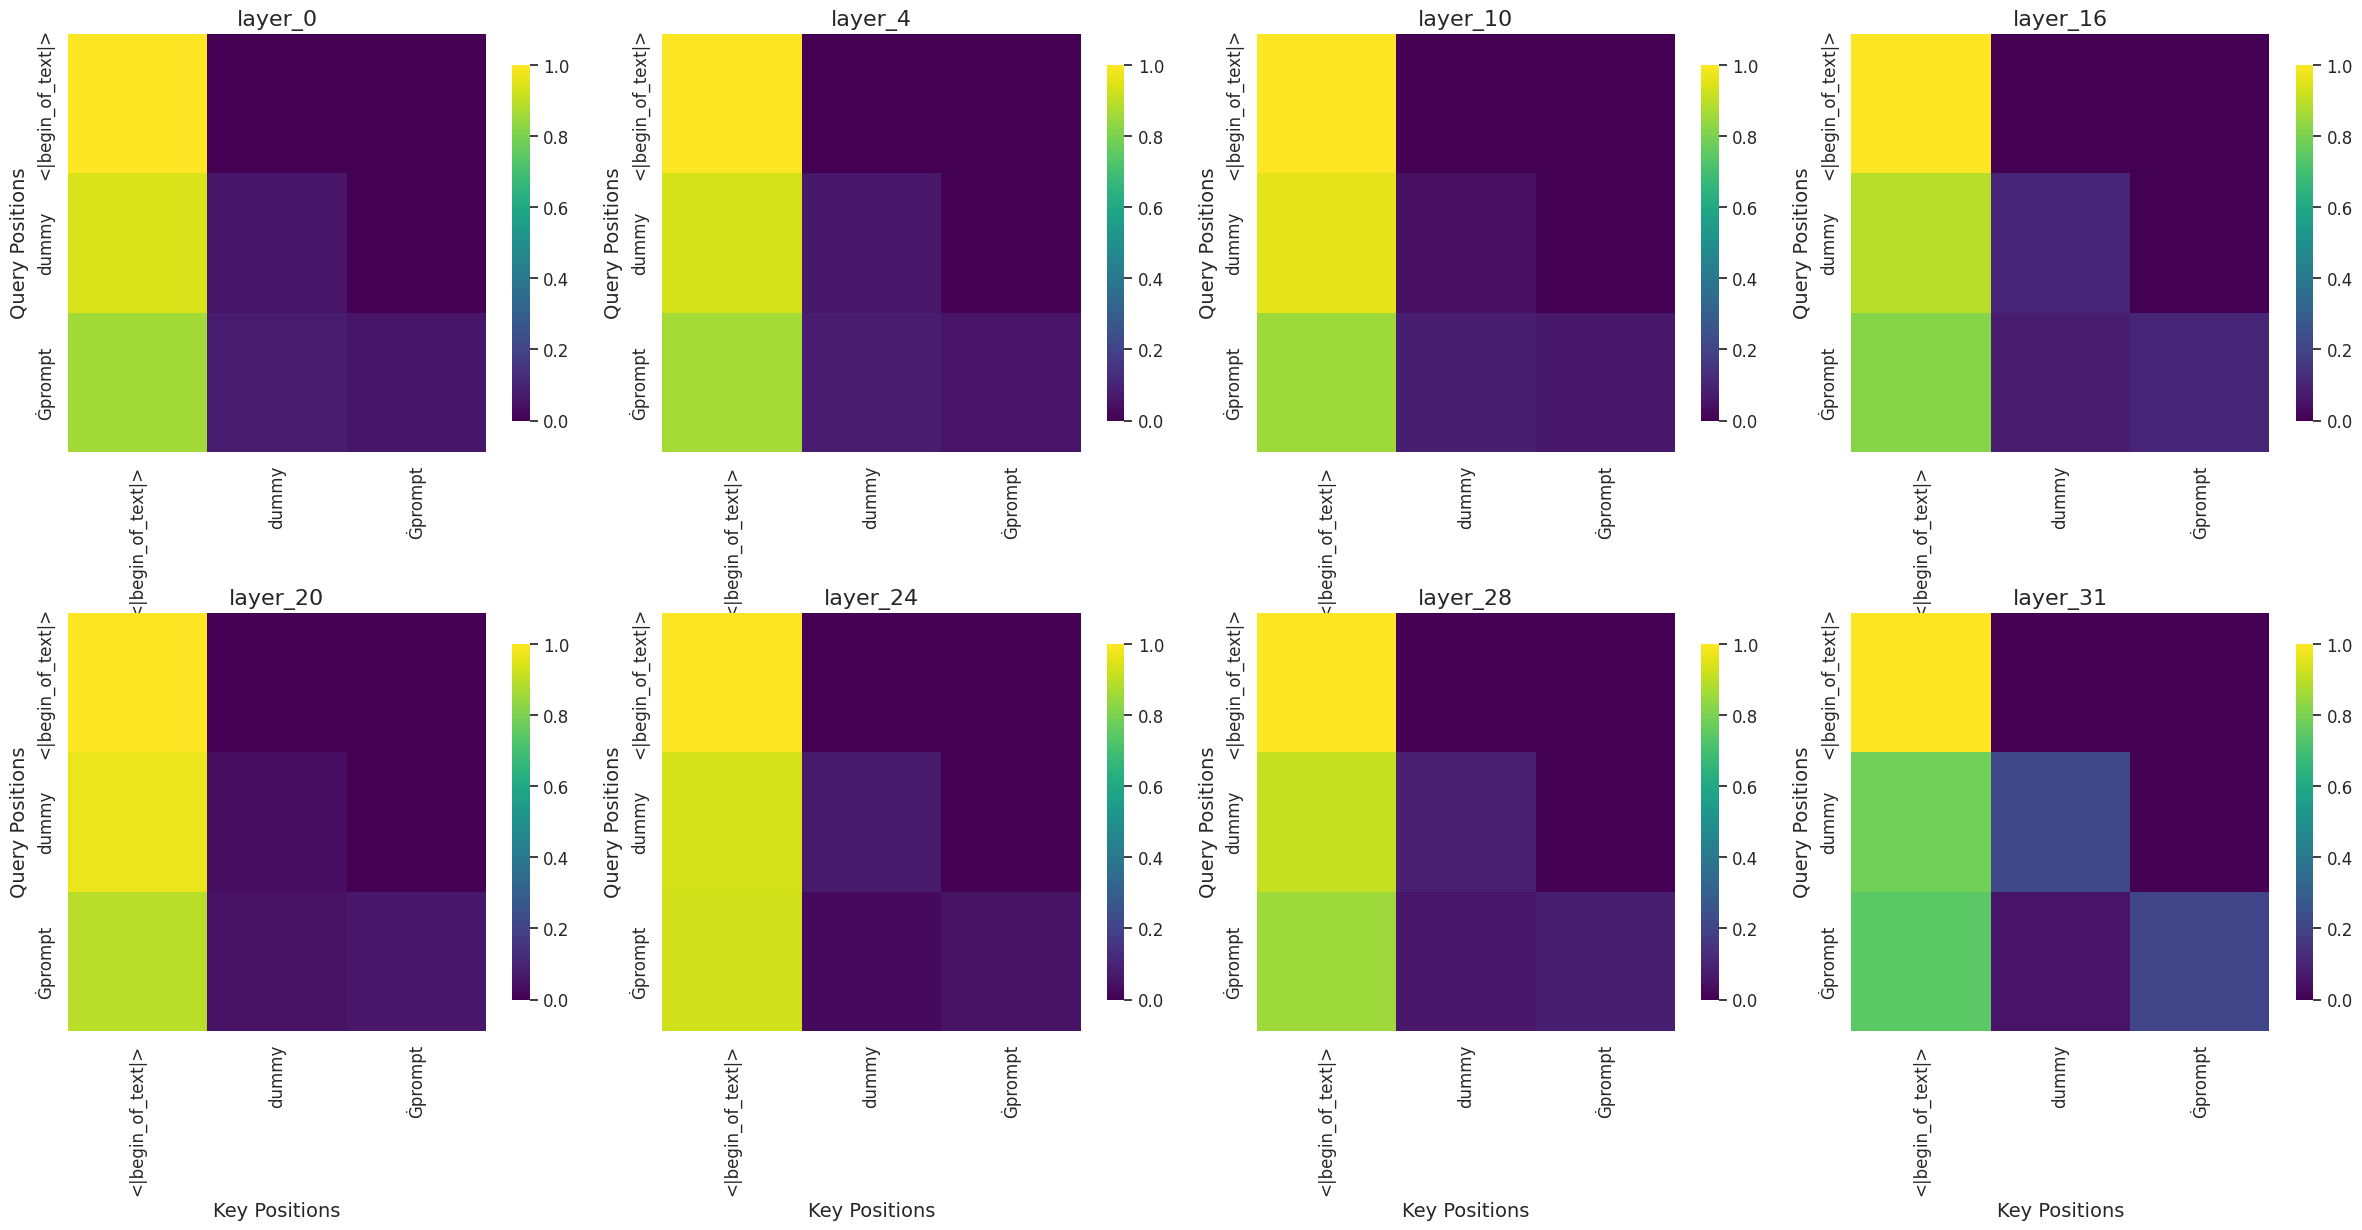

Saved attention map to /content/drive/MyDrive/eml-lab4/figures/short_dummy_attention.png

--- Processing input: short_meaningful ---


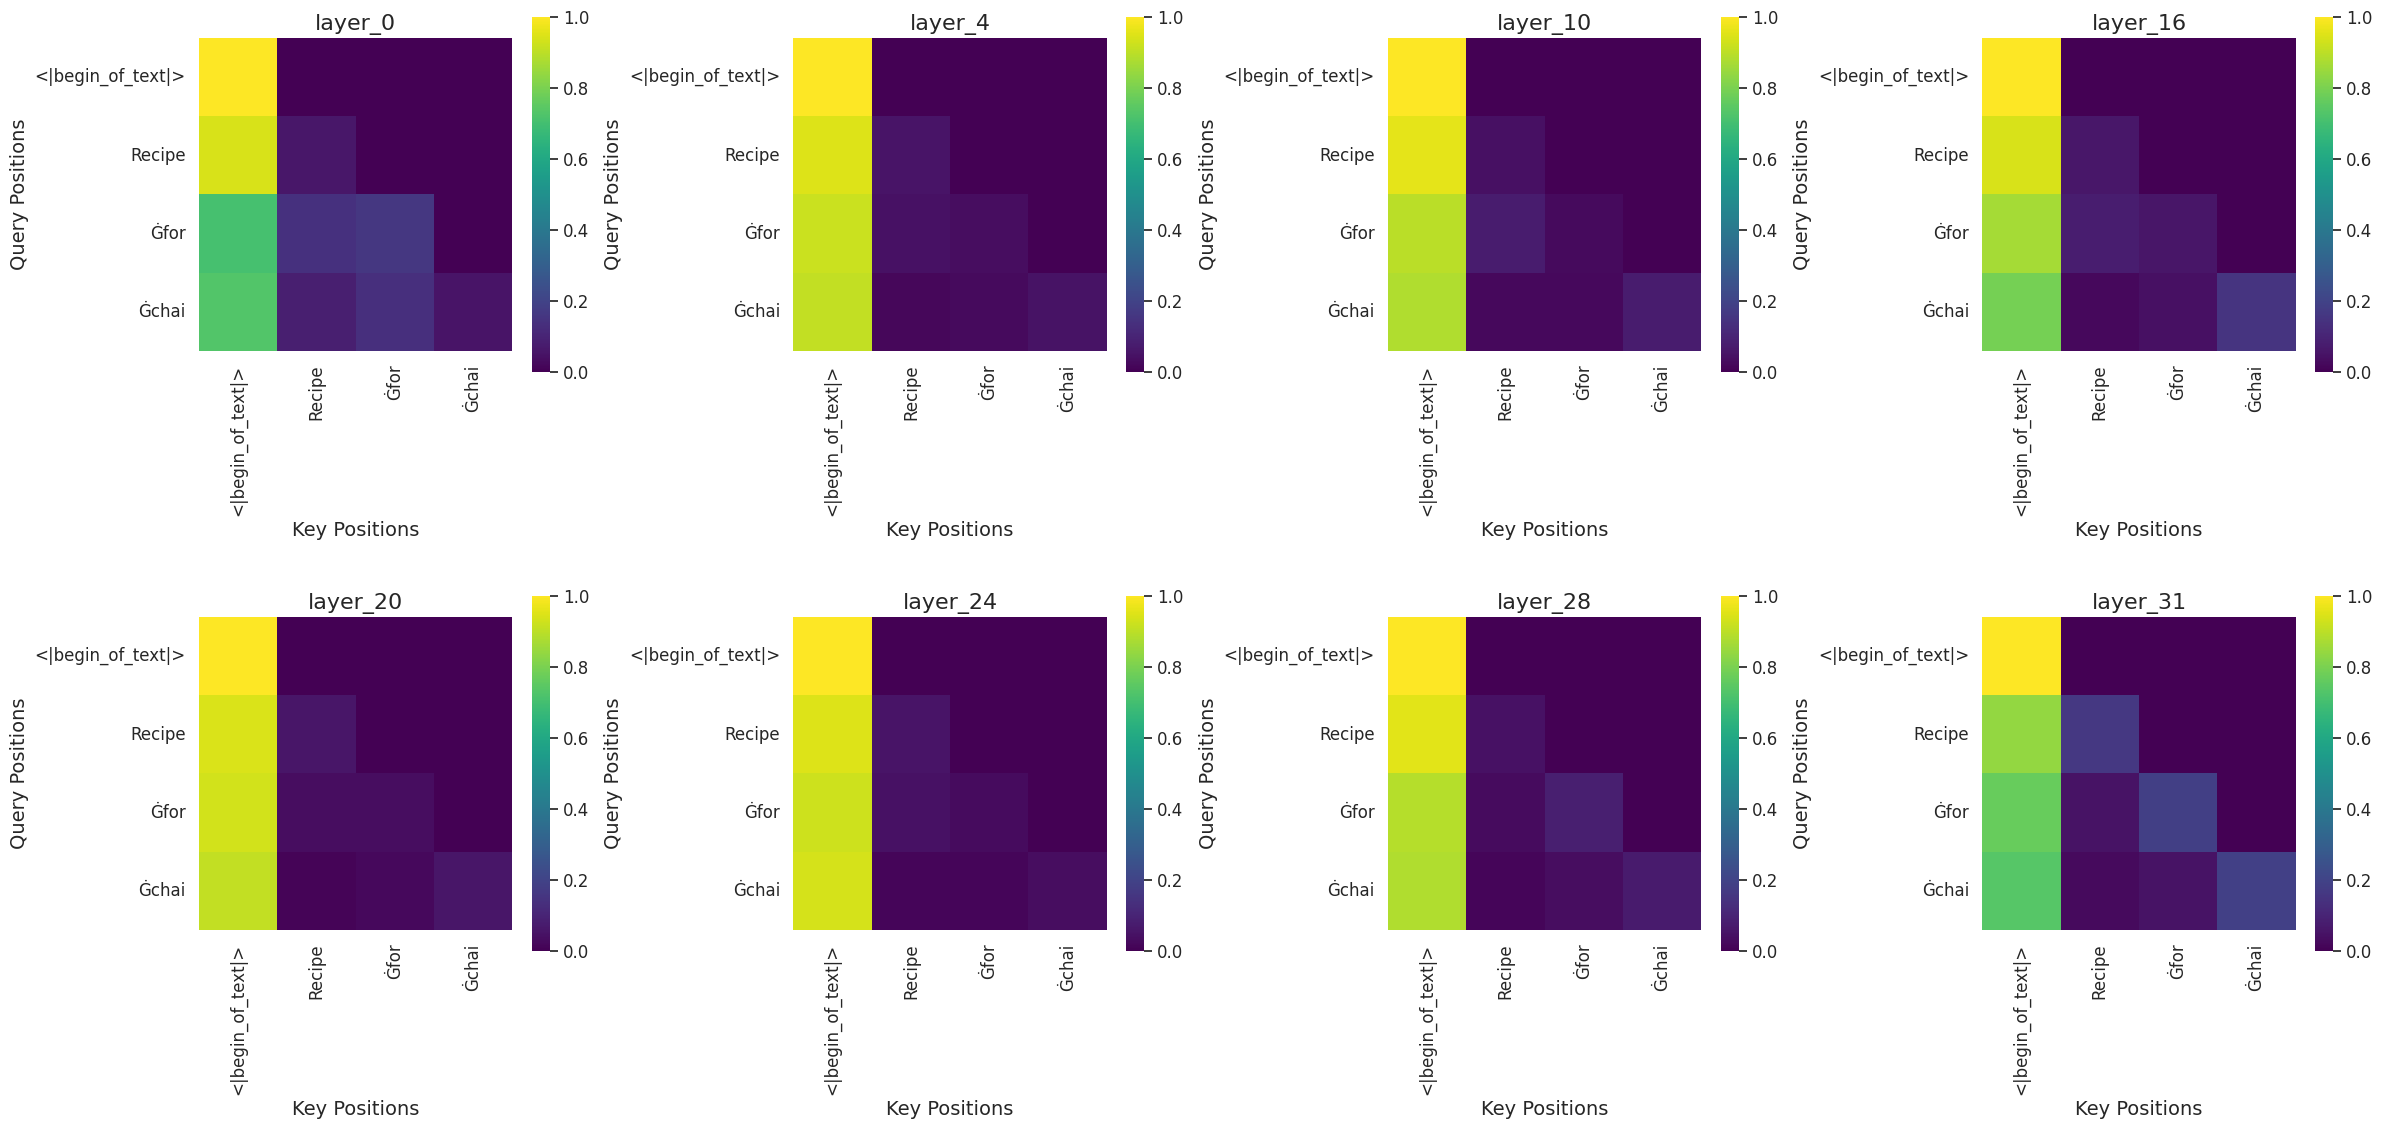

Saved attention map to /content/drive/MyDrive/eml-lab4/figures/short_meaningful_attention.png

--- Processing input: medium_dummy ---


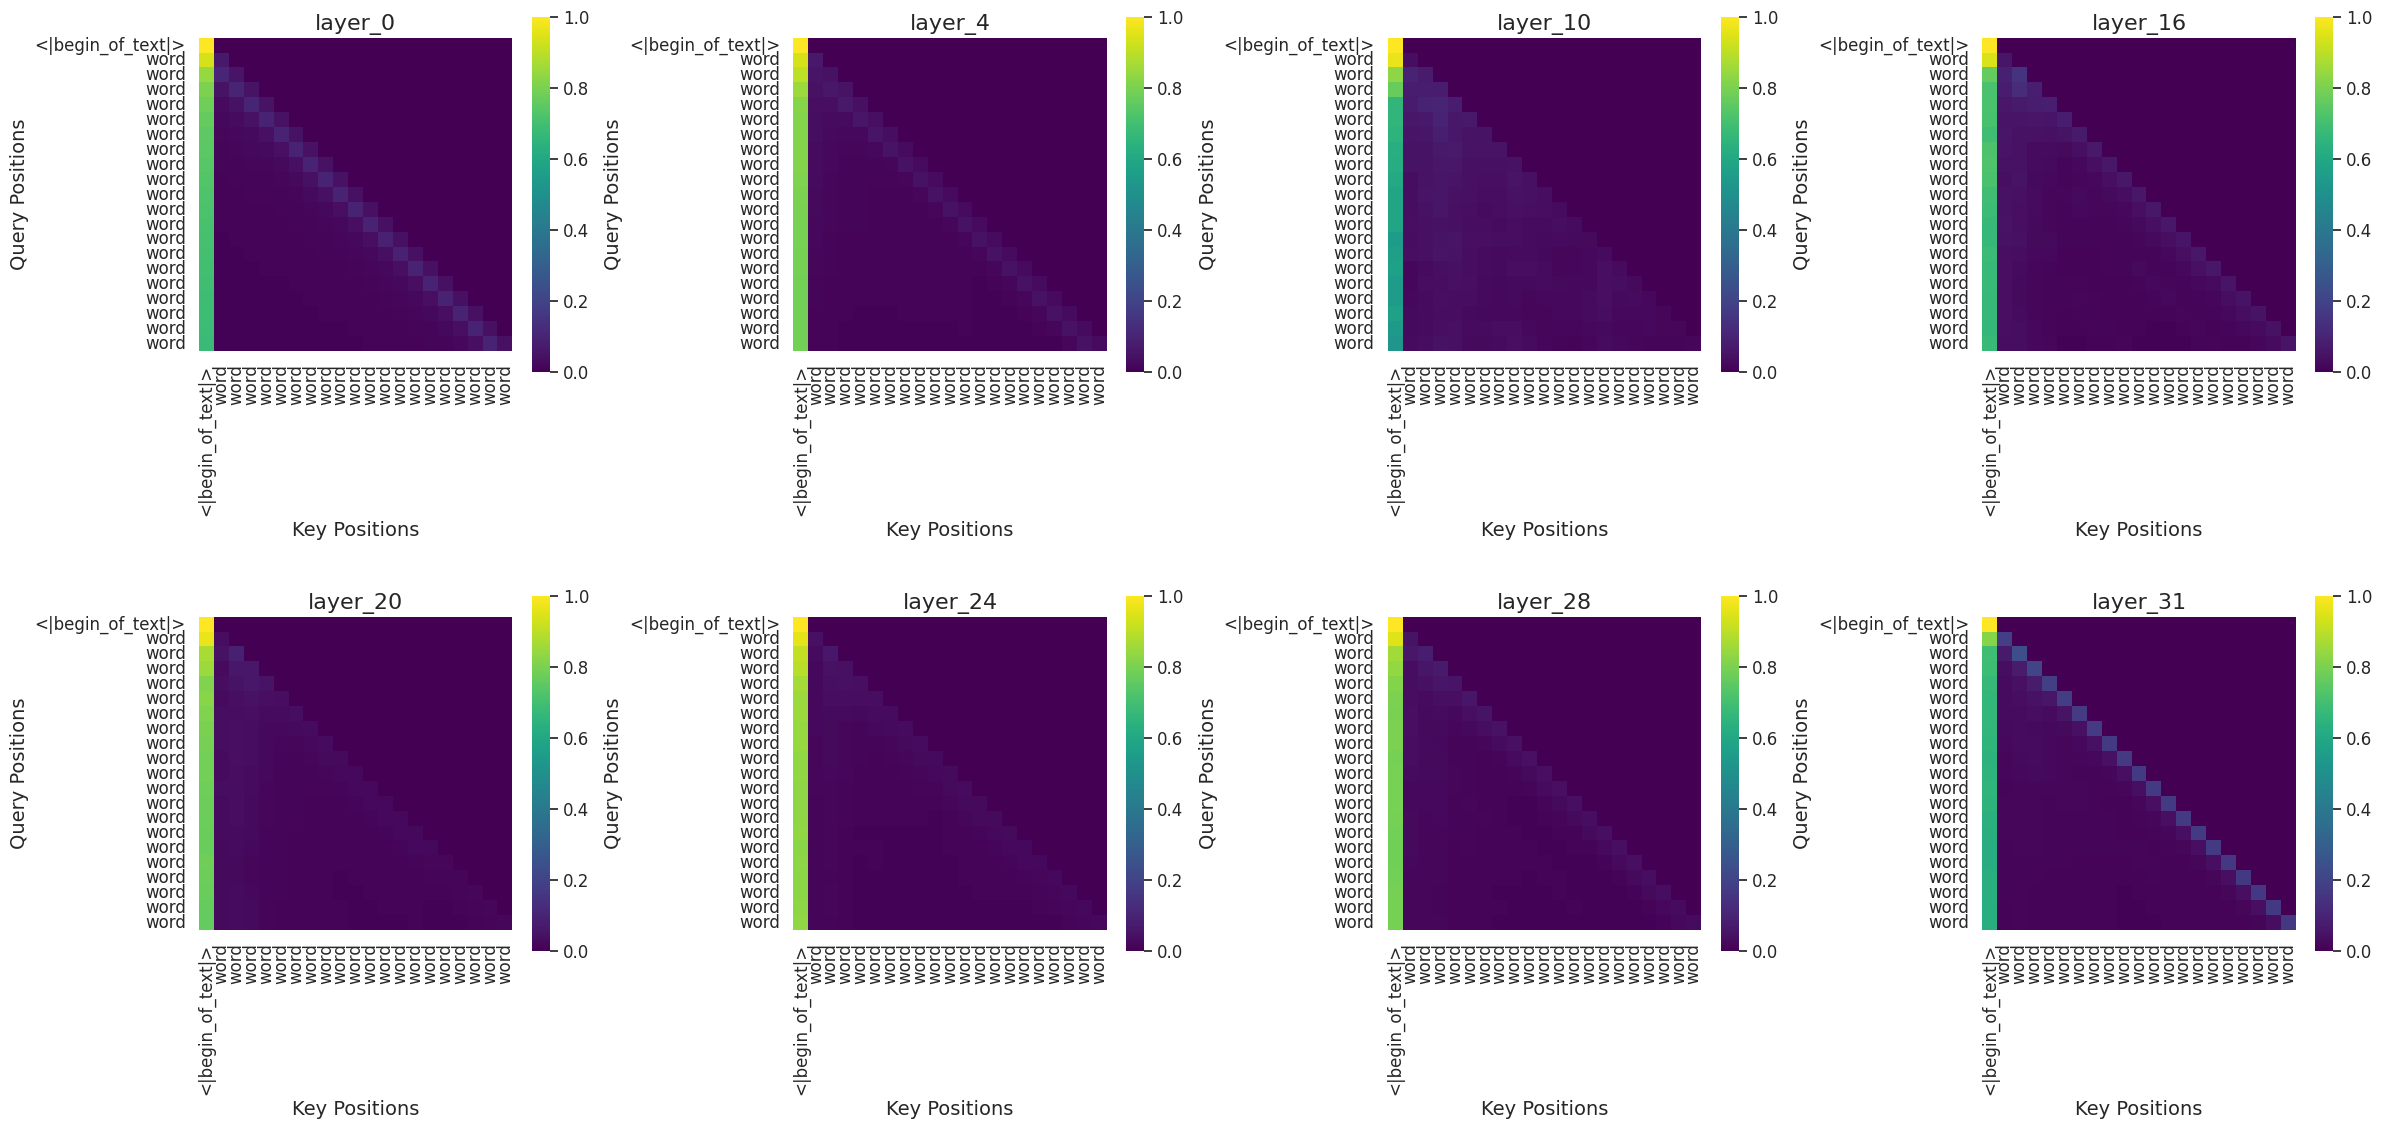

Saved attention map to /content/drive/MyDrive/eml-lab4/figures/medium_dummy_attention.png

--- Processing input: medium_meaningful ---


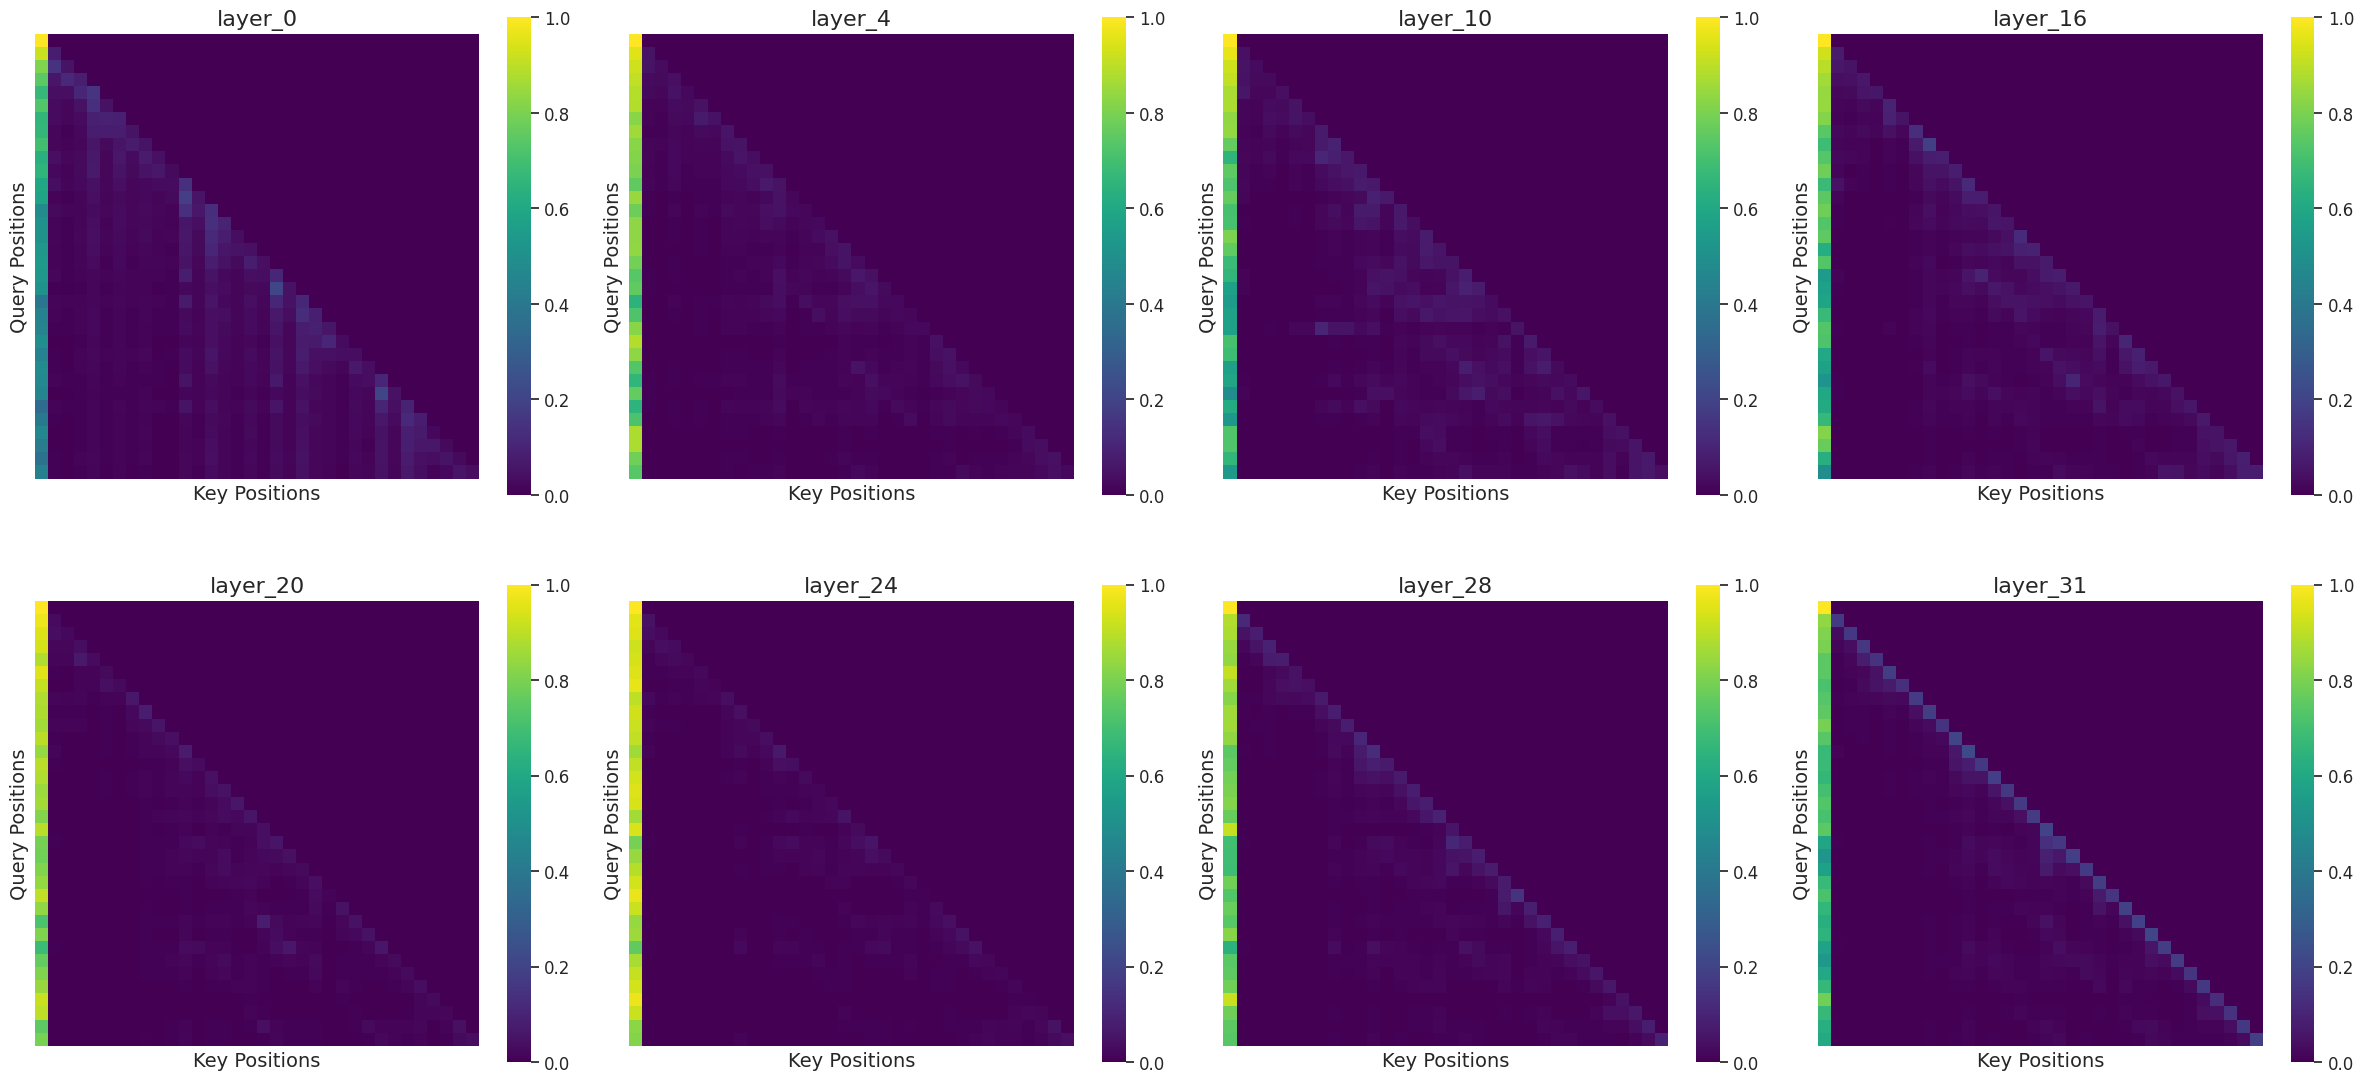

Saved attention map to /content/drive/MyDrive/eml-lab4/figures/medium_meaningful_attention.png

--- Processing input: long_dummy ---


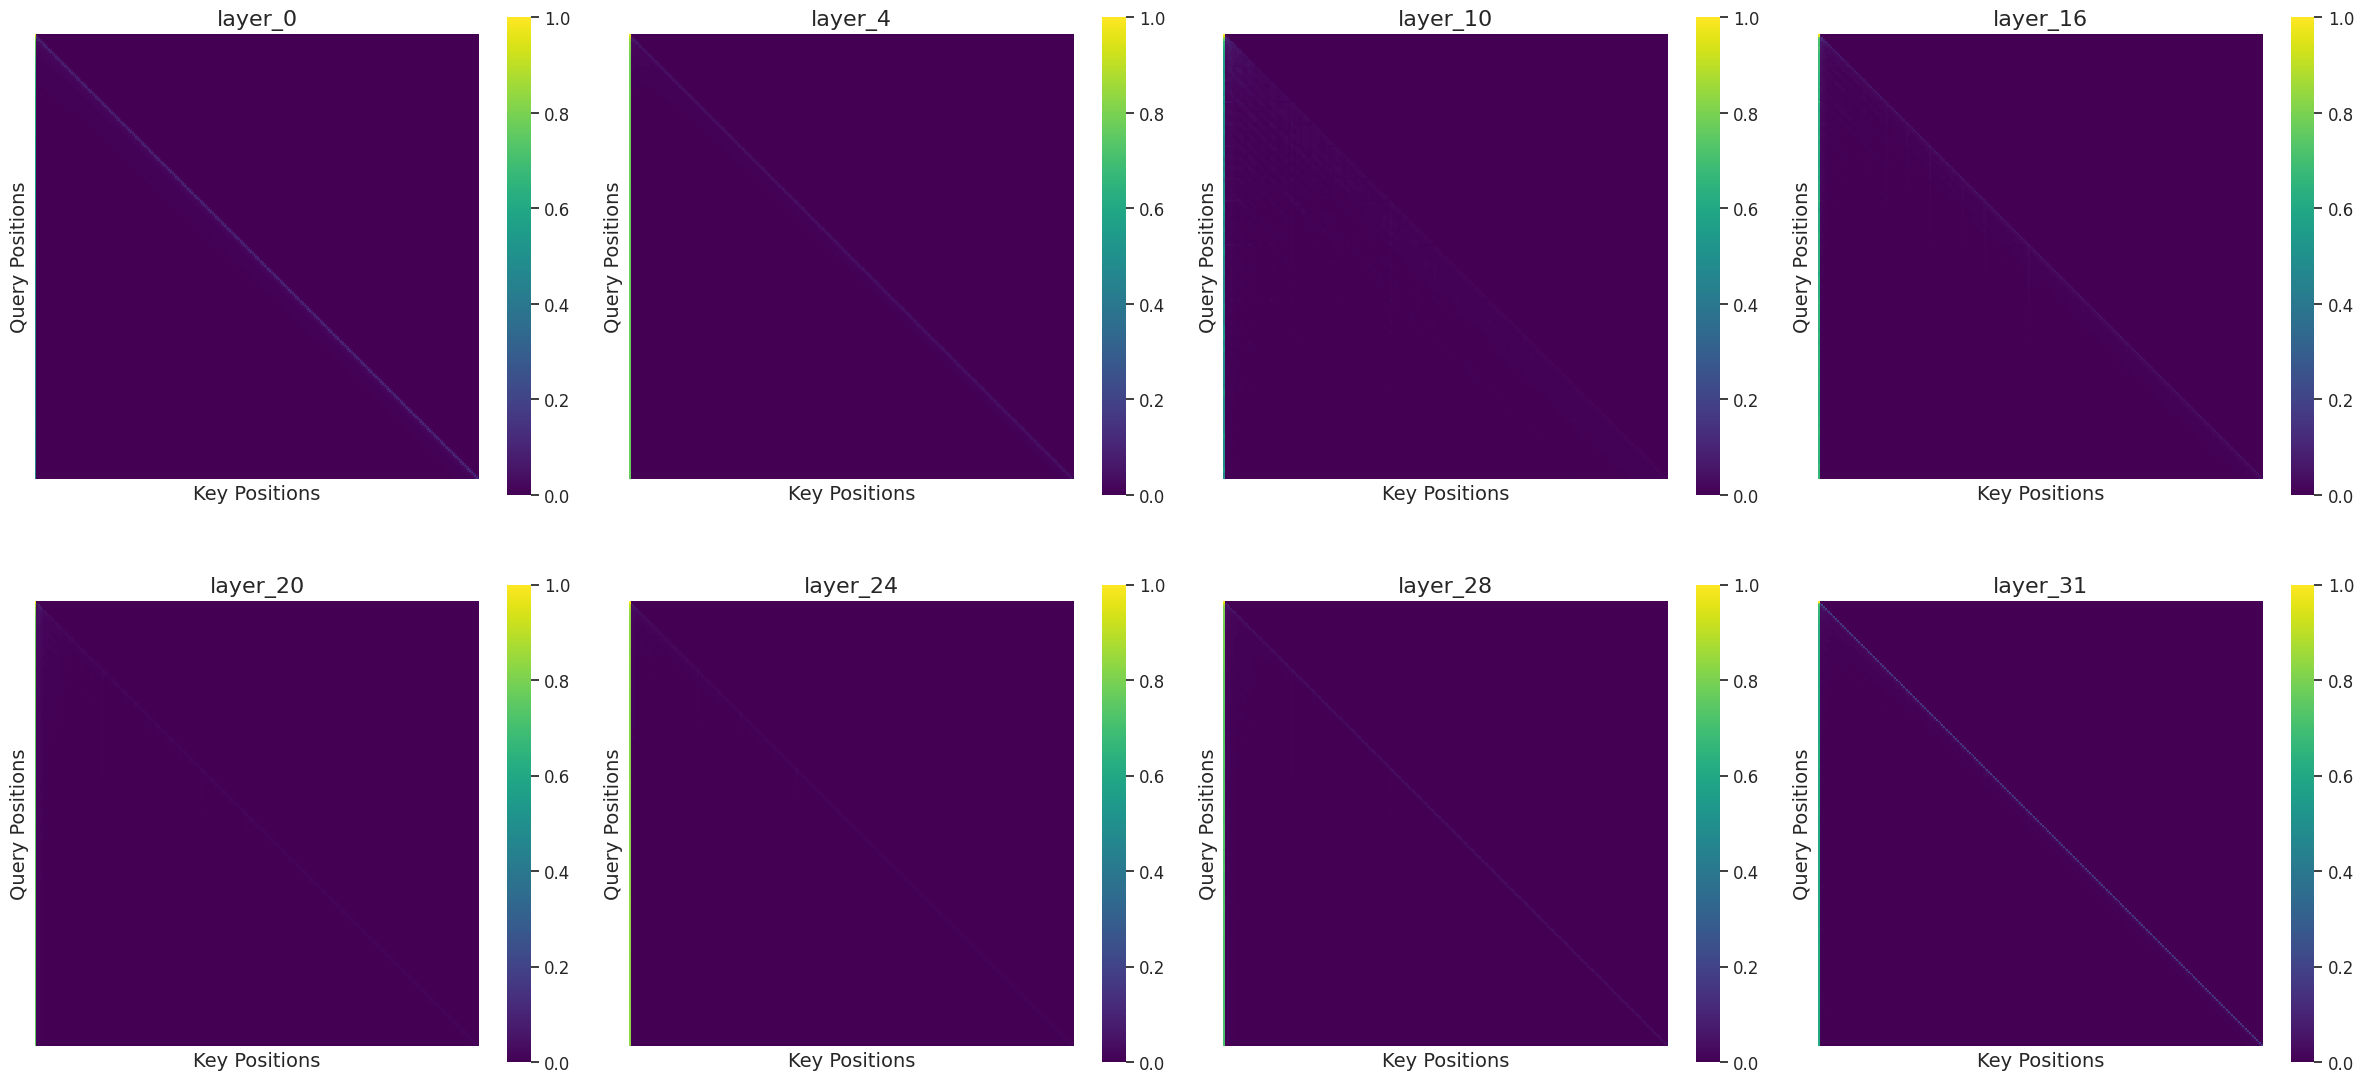

Saved attention map to /content/drive/MyDrive/eml-lab4/figures/long_dummy_attention.png

--- Processing input: long_meaningful ---


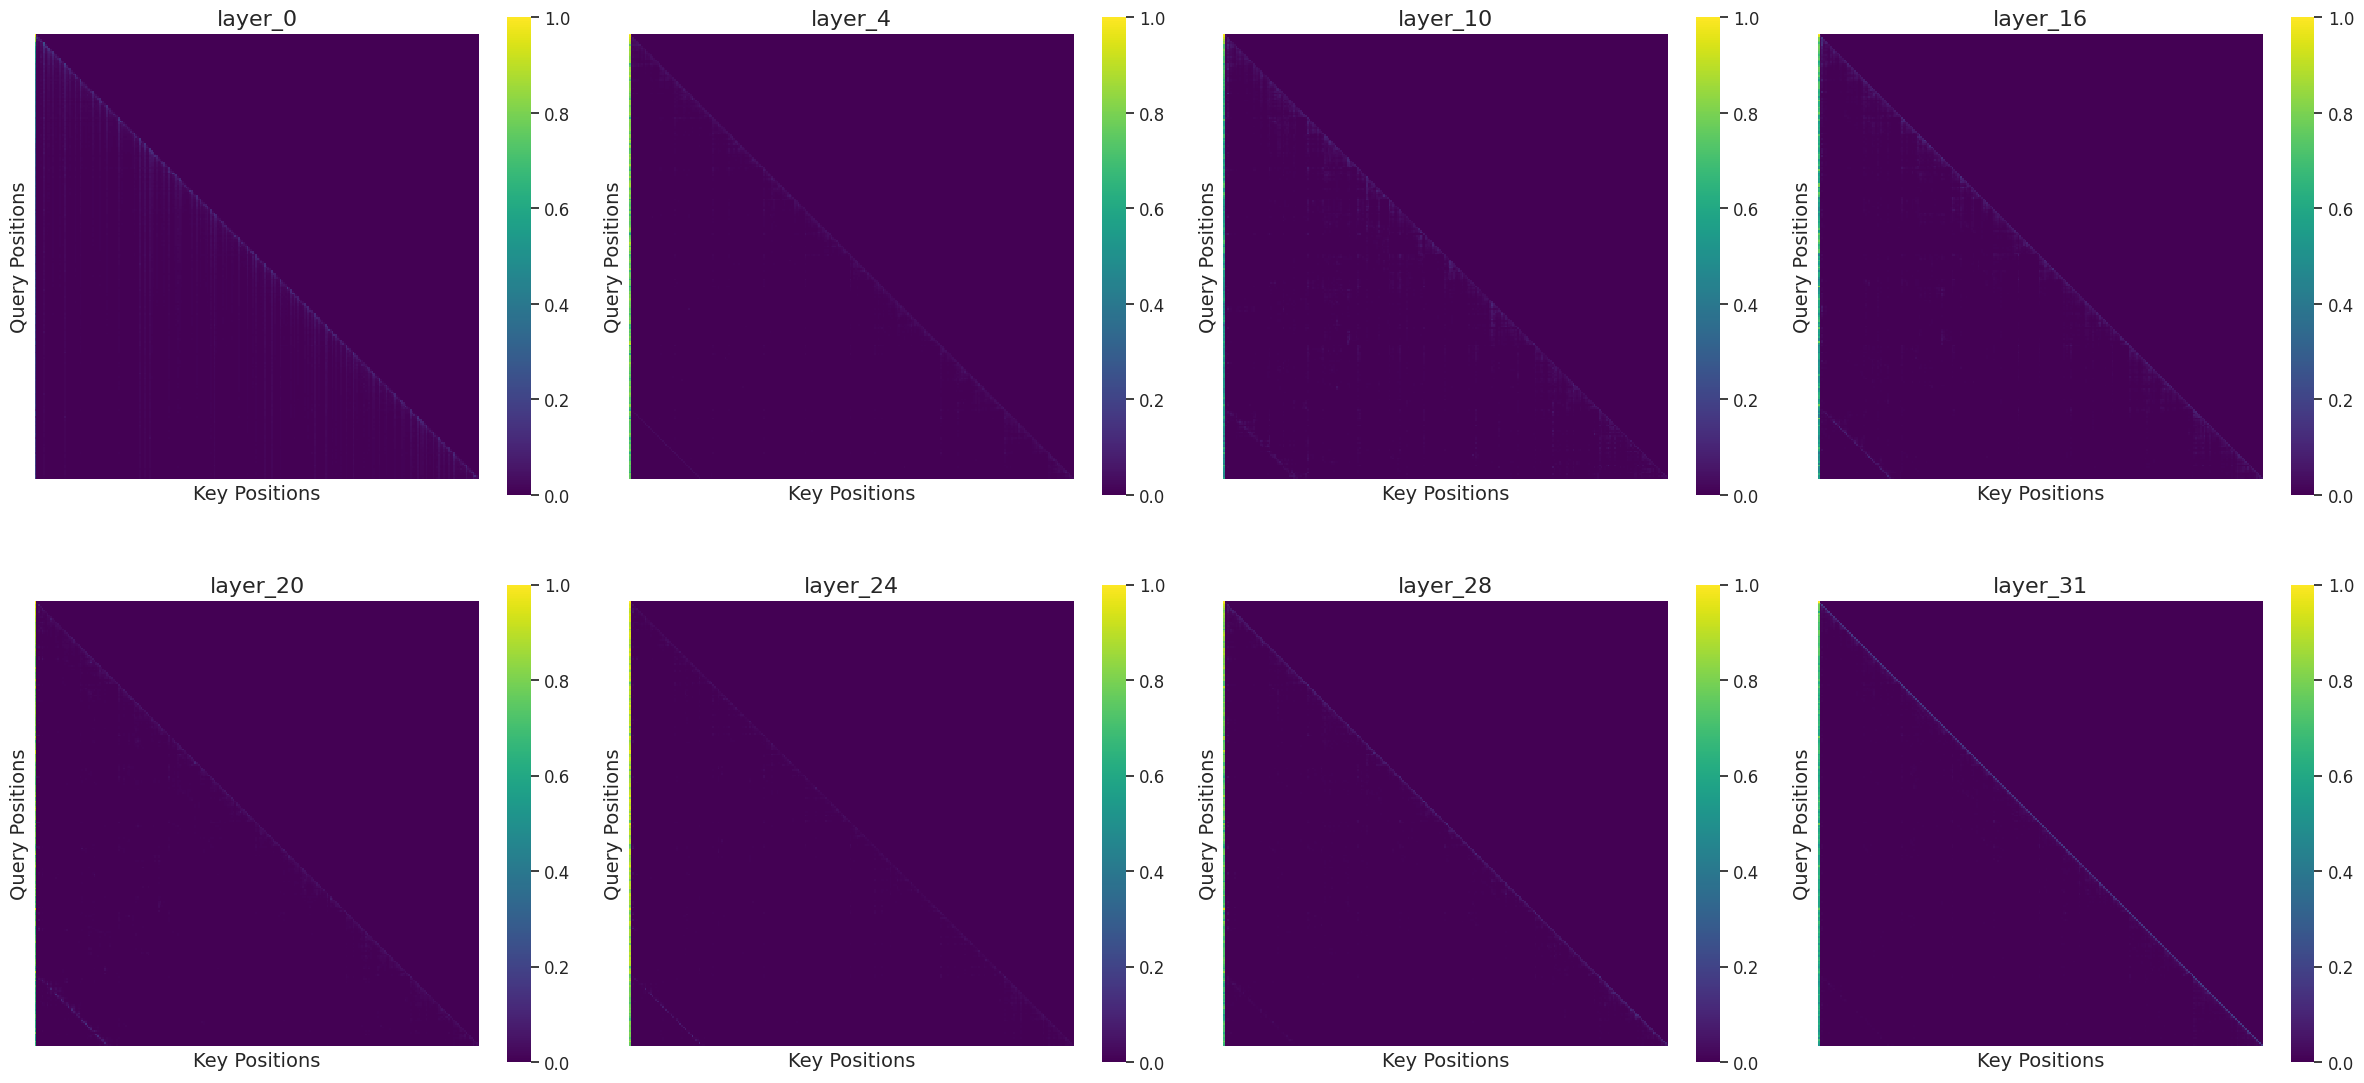

Saved attention map to /content/drive/MyDrive/eml-lab4/figures/long_meaningful_attention.png
dict_keys(['layer_0', 'layer_4', 'layer_10', 'layer_16', 'layer_20', 'layer_24', 'layer_28', 'layer_31'])

   All attention maps for the provided inputs have been generated.


In [13]:
### Cell 6: Experiment - Visualize Attention Maps for Different Inputs

# --- Configurable Section ---
INPUT_TEXTS = {
    "short_dummy": "dummy prompt",  # TODO: provide dummy prompt
    "short_meaningful": "Recipe for chai",  # TODO: provide meaningful prompt
    "medium_dummy": "word" * 20,
    "medium_meaningful": "To get into the Champion's League Everton should sign:\n1. A creative midfielder like\n2. A pacy winger like\n3. A ball-playing defender like",
    "long_dummy": "word" * 600,
    "long_meaningful": (
      "Everton Football Club, one of the oldest and most historic teams in English "
      "football, has experienced a turbulent period in recent years. Supporters often "
      "debate what strategic changes the club should pursue to stabilise performances "
      "and move toward consistent top-half finishes. Analysts highlight several key "
      "areas worth examining: squad depth, recruitment philosophy, managerial tactics, "
      "and the integration of academy players into the senior lineup. Strengthening the "
      "midfield with a dynamic ball-carrier capable of linking defence and attack is "
      "frequently discussed as a priority. Likewise, the team could benefit from "
      "acquiring a reliable goal scorer who excels in both hold-up play and movement "
      "inside the box. Improving defensive organisation, especially during transitions, "
      "remains a critical challenge. Many fans also emphasise the importance of "
      "building a long-term identity that matches the club’s culture, promotes a "
      "coherent playing style, and maximises the potential of young talents at Finch "
      "Farm. Considering these factors, it is worth exploring how Everton can reshape "
      "their approach in the coming seasons and what specific signings or tactical "
      "adjustments would have the most significant impact on their Premier League "
      "trajectory. "
      * 5
  )
}

LAYERS_TO_VISUALIZE = [0, 4, 10, 16, 20, 24, 28, 31]  # TODO: select representative layer indices
if "1b" in MODEL_ID.lower():
    LAYERS_TO_VISUALIZE = [0, 7, 15]  # TODO: adjust layers for smaller models
# ---

# hooks = []  # TODO: register attention hooks for the selected layers
hooks = register_attention_hooks(model, LAYERS_TO_VISUALIZE)

for name, text in INPUT_TEXTS.items():
    print(f"\n--- Processing input: {name} ---")
    attention_maps_storage.clear()
    # TODO: tokenize text, run the model with output_attentions=True, and collect attention maps
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256).to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    plot_attention_maps(attention_maps_storage, tokens, LAYERS_TO_VISUALIZE, name)

print(attention_maps_storage.keys())  # should list layers

# TODO: remove hooks after visualization to avoid memory leaks
for handle in hooks:
    handle.remove()
print("\n   All attention maps for the provided inputs have been generated.")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



--- Starting Experiment: Attention Sink Phenomenon Analysis ---

--- Attention Sink Analysis Results ---
          Input Type       mean        std        min        max
0         long_dummy  72.091843   9.809750  51.624016  89.370079
1    long_meaningful  68.457031  14.832981  28.937008  88.828740
2       medium_dummy  79.929071   6.657669  65.090461  90.460526
3  medium_meaningful  76.365662  10.063505  55.371094  90.625000
4        short_dummy  92.842015   3.237827  79.589844  98.095703
5   short_meaningful  92.231750   3.888200  78.857422  98.095703


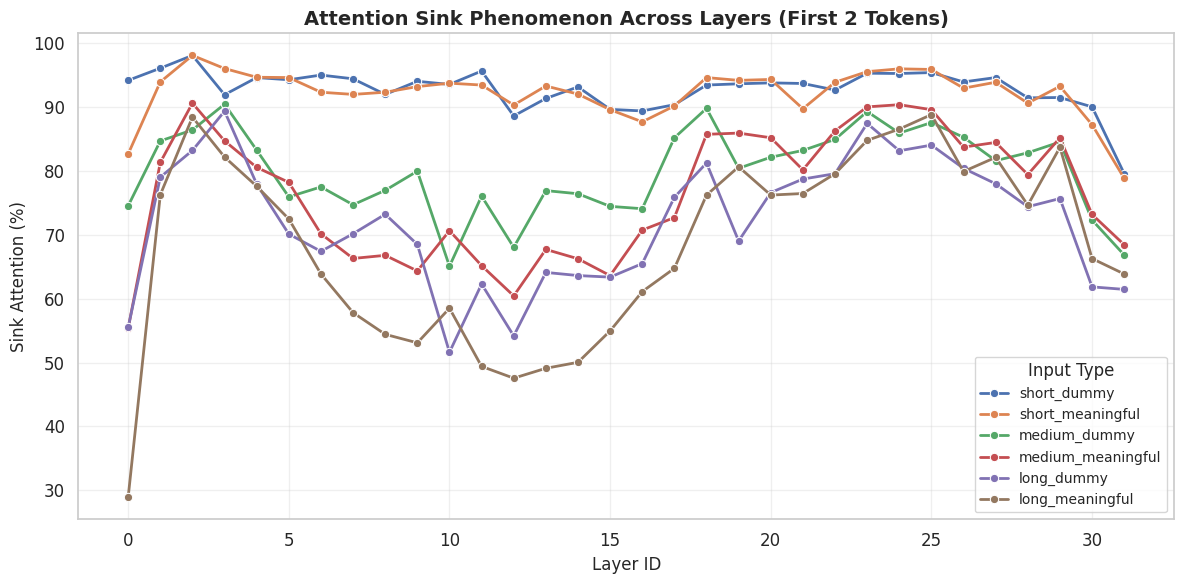


--- Sink Attention by Layer Groups ---
           Input Type Layer Group  Sink Attention (%)
0          long_dummy       Early           71.470115
1          long_dummy      Middle           67.593504
2          long_dummy        Late           76.802971
3     long_meaningful       Early           64.880100
4     long_meaningful      Middle           61.011319
5     long_meaningful        Late           78.802792
6        medium_dummy       Early           79.055772
7        medium_dummy      Middle           78.363487
8        medium_dummy        Late           82.225628
9   medium_meaningful       Early           73.557351
10  medium_meaningful      Middle           72.358398
11  medium_meaningful        Late           82.816939
12        short_dummy       Early           94.388951
13        short_dummy      Middle           91.914062
14        short_dummy        Late           92.138672
15   short_meaningful       Early           93.061967
16   short_meaningful      Middle         

/tmp/ipython-input-1945396579.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  layer_group_stats = df_sink.groupby(['Input Type', 'Layer Group'])['Sink Attention (%)'].mean().reset_index()


'\n#### Attention Sink Phenomenon Analysis\n\n**Observed Phenomena:**\n\n**Analysis:**\n\n'

In [14]:
### Cell 7: Experiment - Attention Sink Phenomenon Analysis

print("\n--- Starting Experiment: Attention Sink Phenomenon Analysis ---")
# --- Configurable Section ---
SINK_TOKEN_WINDOW = 2  # TODO: choose number of initial tokens treated as sink tokens
# ---

sink_analysis_results = []
# hooks = []  # TODO: register attention hooks across all layers
hooks = register_attention_hooks(model, range(model.config.num_hidden_layers))

for name, text in INPUT_TEXTS.items():
    attention_maps_storage.clear()
    # TODO: tokenize text and run the model to capture attention maps
    inputs = tokenizer(text, return_tensors="pt", max_length=256).to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    for layer_idx in range(model.config.num_hidden_layers):
        layer_name = f"layer_{layer_idx}"
        if layer_name in attention_maps_storage:
            # TODO: compute sink attention statistics and append to sink_analysis_results
            attn_map = attention_maps_storage[layer_name][0].mean(dim=0)
            sink_attention_strength = attn_map[SINK_TOKEN_WINDOW:, :SINK_TOKEN_WINDOW].sum().item()
            total_attention = attn_map[SINK_TOKEN_WINDOW:, :].sum().item()
            sink_percentage = (sink_attention_strength / total_attention) * 100 if total_attention > 0 else 0
            sink_analysis_results.append({"Input Type": name, "Layer ID": layer_idx, "Sink Attention (%)": sink_percentage})

# TODO: remove hooks after analysis
for handle in hooks:
    handle.remove()

# TODO: convert sink_analysis_results into a DataFrame and save to disk
df_sink = pd.DataFrame(sink_analysis_results)
df_sink.to_csv(os.path.join(RESULTS_DIR, "task2_attention_sink_analysis.csv"), index=False)

# TODO: plot sink attention percentage vs. layer depth for each input type
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_sink,
    x="Layer ID",
    y="Sink Attention (%)",
    hue="Input Type",
    marker="o",
    linewidth=2
)
plt.title(f"Attention Sink Phenomenon Across Layers (First {SINK_TOKEN_WINDOW} Tokens)", fontsize=14, fontweight='bold')
plt.xlabel("Layer ID", fontsize=12)
plt.ylabel("Sink Attention (%)", fontsize=12)
plt.legend(title="Input Type", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "task2_attention_sink_analysis.png"), dpi=300)

print("\n--- Attention Sink Analysis Results ---")
summary = df_sink.groupby("Input Type")["Sink Attention (%)"].agg(['mean', 'std', 'min', 'max']).reset_index()
print(summary)

plt.show()

# Additional statistics by layer groups
print("\n--- Sink Attention by Layer Groups ---")
df_sink['Layer Group'] = pd.cut(df_sink['Layer ID'], bins=3, labels=['Early', 'Middle', 'Late'])
layer_group_stats = df_sink.groupby(['Input Type', 'Layer Group'])['Sink Attention (%)'].mean().reset_index()
print(layer_group_stats)

"""
#### Attention Sink Phenomenon Analysis

**Observed Phenomena:**

**Analysis:**

"""


In [ ]:
### Cell 8: Bonus Experiment: Modify Standard Attention to StreamingLLM Attention (Task 2 Step 4)
# TODO: import required modules for custom attention (transformers attention utilities, logging, torch.nn, types)
# from transformers.modeling_utils import ALL_ATTENTION_FUNCTIONS
# from transformers.models.llama.modeling_llama import LlamaAttention, rotate_half, repeat_kv
# from transformers.utils import logging
# import torch.nn as nn
# import types


def eager_attention_forward(
    module: nn.Module,
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    attention_mask: Optional[torch.Tensor],
    scaling: float,
    dropout: float = 0.0,
    **kwargs,
):
    """
    Implements the standard (eager) attention forward pass.
    """
    key_states = repeat_kv(key, module.num_key_value_groups)
    value_states = repeat_kv(value, module.num_key_value_groups)

    attn_weights = torch.matmul(query, key_states.transpose(2, 3)) * scaling
    if attention_mask is not None:
        causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
        attn_weights = attn_weights + causal_mask

    attn_weights = nn.functional.softmax(
        attn_weights, dim=-1, dtype=torch.float32
    ).to(query.dtype)
    attn_weights = nn.functional.dropout(
        attn_weights, p=dropout, training=module.training
    )
    attn_output = torch.matmul(attn_weights, value_states)
    attn_output = attn_output.transpose(1, 2).contiguous()

    return attn_output, attn_weights

def apply_rotary_pos_emb_single(x, cos, sin, position_ids):
    """
    Applies rotary positional embedding to a single tensor.
    """
    # Remove singleton dimensions for broadcasting
    cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    x_embed = (x * cos) + (rotate_half(x) * sin)
    return x_embed

def apply_rotary_pos_emb_q(q, cos, sin, unsqueeze_dim=1):
    """
    Applies rotary positional embedding to the query tensor.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    return q_embed


# TODO: refer to https://github.com/mit-han-lab/streaming-llm/blob/main/streaming_llm/pos_shift/modify_llama.py
# modify to fit llama3 architecture
def llama_pos_shift_attention_forward(self, hidden_states, position_embeddings, attention_mask, past_key_value, cache_position=None, **kwargs):
    """Modified LLaMA attention forward pass with position shifting for StreamLLM."""
    # TODO: project QKV, update caches, apply rotary embeddings, and compute attention outputs
    ...

def enable_llama_pos_shift_attention(model):
    """Replace standard LlamaAttention.forward methods with the position-shifted variant."""
    # TODO: recursively locate LlamaAttention modules and bind llama_pos_shift_attention_forward
    ...


In [ ]:
### Cell 9: Bonus Experiment: Investigate StreamLLM's Impact on Long-Sequence Memory Usage
# TODO: import tqdm for progress visualisation
# from tqdm.auto import tqdm

print("\n--- Starting Bonus Experiment: Simulating StreamLLM Memory Impact ---")

# --- Configurable Section ---
BONUS_PROMPT = "..."  # TODO: provide long-form prompt
BONUS_GENERATION_LENGTH = ...  # TODO: choose number of tokens to generate
BONUS_SAMPLING_INTERVAL = ...  # TODO: sampling interval for memory measurements
STREAMLLM_CACHE_SIZE = ...  # TODO: number of sink tokens to retain
STREAMLLM_RECENT_SIZE = ...  # TODO: number of most recent tokens to retain
# ---

def run_baseline_experiment(model, tokenizer, prompt, generation_length, sampling_interval, device):
    """Run baseline generation with the standard KV cache while logging memory usage."""
    # TODO: implement generation loop without cache eviction and record GPU memory
    ...

class streamingllm_kv:
    """Implement StreamLLM-style KV cache eviction (retain sink + recent tokens)."""
    def __init__(self, start_size, recent_size, past_key_values):
        # TODO: store configuration for cache trimming
        ...

    def __call__(self, kv_cache):
        """Trim the KV cache according to the StreamLLM policy."""
        # TODO: drop middle tokens while retaining sink and recent tokens
        ...

def run_streamllm_experiment(model, tokenizer, prompt, generation_length, sampling_interval, sink_size, recent_size, device):
    """Run generation with StreamLLM cache eviction and record memory usage."""
    # TODO: enable modified attention, apply streaming cache policy, and log memory
    ...

# =================================================================================
# Main Execution Flow
# =================================================================================

# TODO: prepare chat-formatted prompt and run both baseline and StreamLLM experiments
# messages = [...]
# BONUS_PROMPT = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
# memory_baseline, last100words_baseline = run_baseline_experiment(...)
# memory_streamllm, last100words_streamllm = run_streamllm_experiment(...)

# TODO: collate memory usage results, save CSV artifacts, and plot comparisons
# df_mem_compare = pd.concat([...])
# df_mem_compare.to_csv("./results/task2_bonus_memory_comparison.csv", index=False)
# sns.lineplot(...)
# plt.savefig("./figures/task2_bonus_memory_comparison.png", dpi=300)

# TODO: decode and print the final segments from each generation for qualitative comparison
# print(tokenizer.decode(last100words_baseline))
# print(tokenizer.decode(last100words_streamllm))


In [ ]:
### Cell 10: List all generated artifacts for Task 2
print("Task 2 complete. Generated artifacts:")

# TODO: iterate over output directories and list generated files
# if os.path.isdir(FIGURES_DIR):
#     ...
# if os.path.isdir(RESULTS_DIR):
#     ...
